## Librerias

In [ ]:
pip install opencv-python

In [2]:
# Instalacion librerias
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt
import imageio
from skimage.util import random_noise
from PIL import Image, ImageTk
from sklearn.cluster import MeanShift, estimate_bandwidth

In [3]:
# Mis funciones
import funciones_pdi as nf

## Funciones para calcular y dibujar Histograma

In [4]:
def calculate_histogram(values, ax):
#     fig, ax = plt.subplots(figsize=(4, 3))
    ax.set(title='Histograma')
    n, bins, patches = ax.hist(values, bins=20, range=(0,1), density=True)    
    altura_total = np.sum(n)
    factor_de_escala = 100 / altura_total
    n *= factor_de_escala
    # Graficar el histograma escalado
    ax.bar(bins[:-1], n, width=np.diff(bins), align="edge", edgecolor='black')
    # Establecer límite en el eje y hasta 100%
    ax.set_ylim(0, 100)
    
def show_images(values, title):
    fig, ax = plt.subplots()
    ax.imshow(values, 'gray')
    ax.set_title(title)
    fig.set_size_inches(18, 10, forward=True)

    fig, ax2 = plt.subplots()
    calculate_histogram(values.flatten(), ax2)

# Carga de imagen de Estudio

Al leer la imagen se la normaliza en en el intervalo [0,1] para luego pasar al formato YIQ. Se dibuja el histograma de luminancias de la banda Y

C:\Users\Fabian\AppData\Local\Temp\ipykernel_21692\3561209187.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread('imagenes/ponds.bmp')


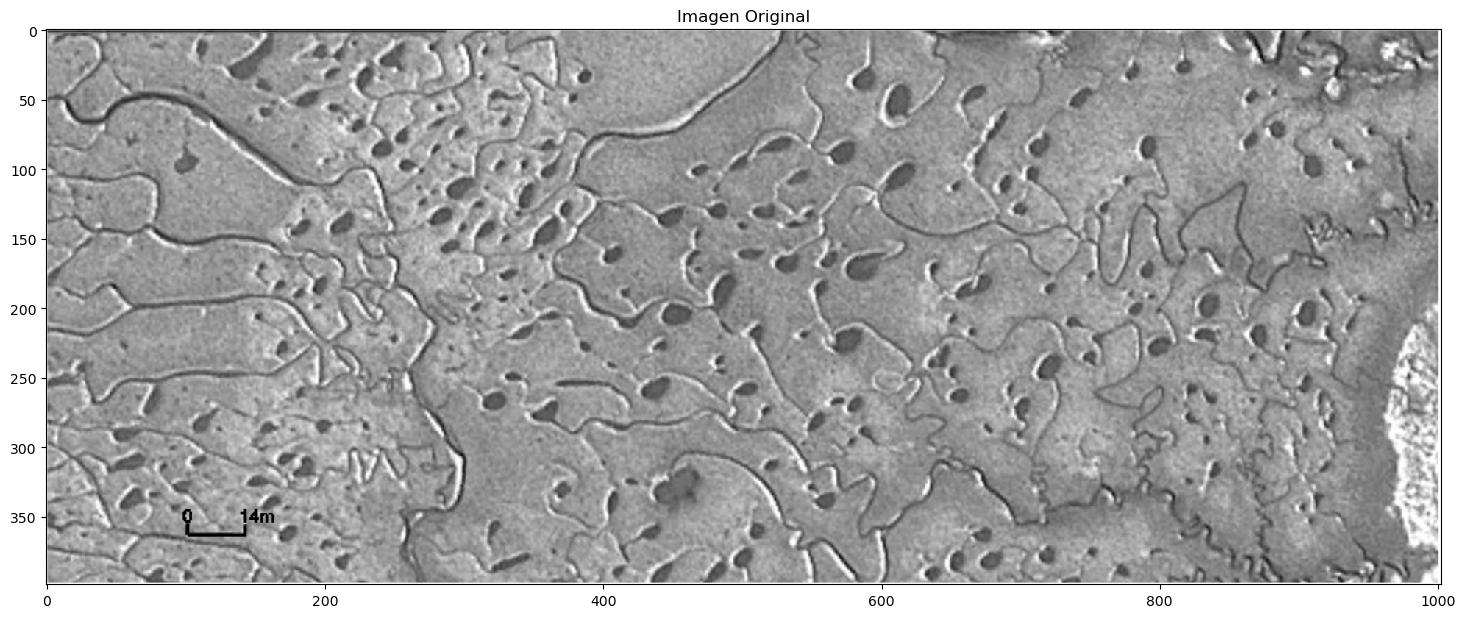

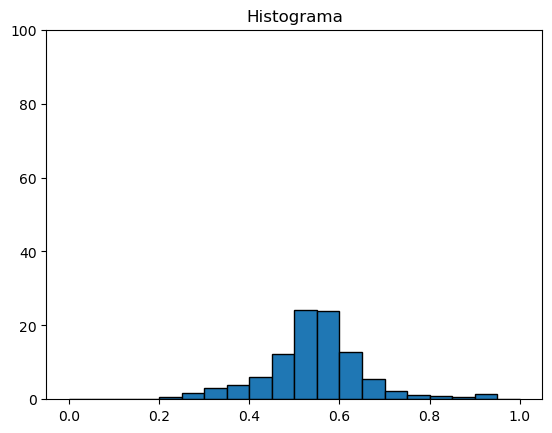

In [16]:
im = imageio.imread('imagenes/ponds.bmp')

im = np.clip(im/255.,0.,1.) #normalizando [0,1]

yiq = np.clip(nf.RGB_to_YIQ(im),0.,1.)
bandaY = yiq[:,:,0]
show_images(bandaY,'Imagen Original')

Para mejorar el histograma se aplica la funcion lineal a trozos como filtro para distribuir el histograma en todo el intervalo [0.1]

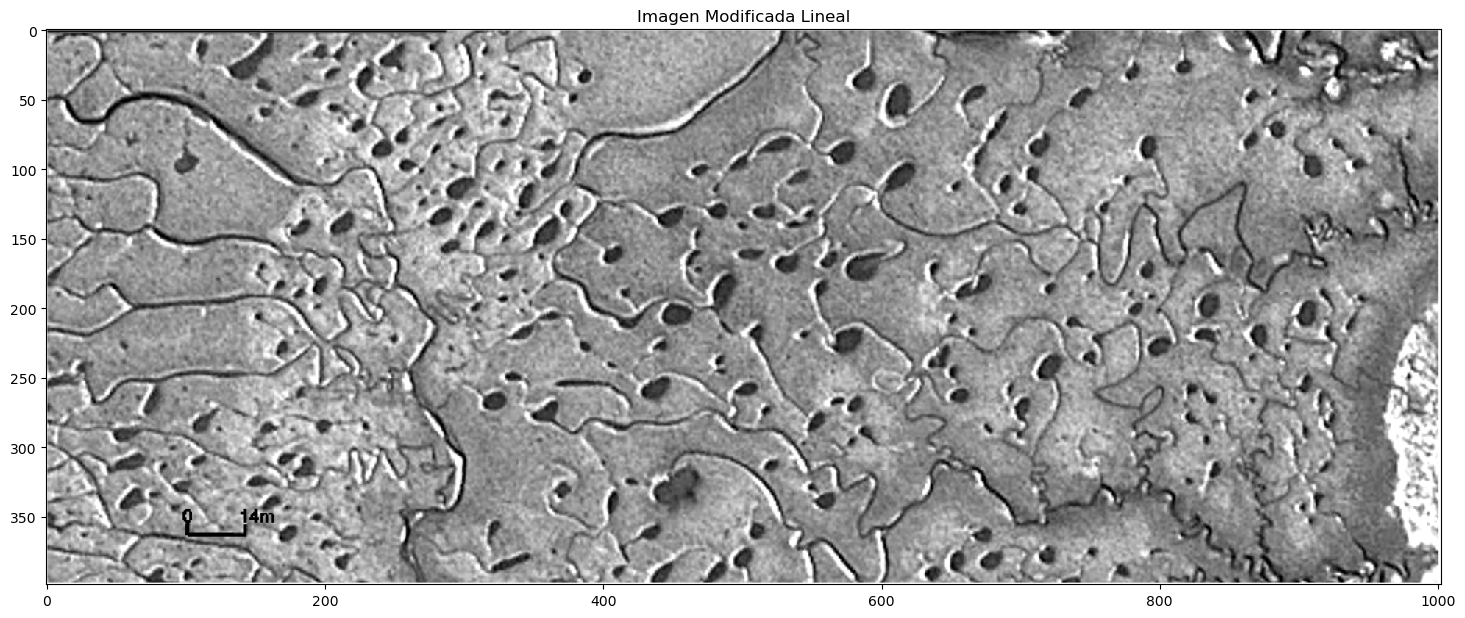

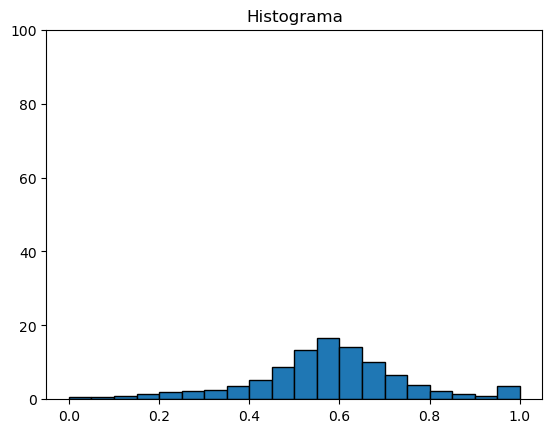

In [17]:
yiq_lineal = nf.histogram_lineal(yiq, 0.2, 0.8)
bandaY_lineal = yiq_lineal[:,:,0]
show_images(bandaY_lineal,'Imagen Modificada Lineal')

Una vez mejorada la imagen se convierte nuevamente a su formato RGB

In [28]:
img_rgb = nf.YIQ_to_RGB(yiq_lineal)
img_rgb = np.clip((img_rgb*255),0,255).astype(np.uint8)

## MeanShift

Es un algoritmo de aprendizaje no supervisado que se utiliza principalmente para la agrupación o Clustering.
EL nombre de la técnica deriva del hecho de que en cada iteración del algoritmo hay un “desplazamiento de la media”.
En esta aplicación especifica, el algoritmo lo que hace es que para cada píxel de una imagen (que tiene una ubicación espacial y un color particular), se determina el conjunto de píxeles vecinos (dentro de un radio espacial y una distancia de color definida). Para este conjunto de píxeles vecinos, se calculan el nuevo centro espacial (media espacial) y el nuevo valor medio de color. Estos valores medios calculados servirán como el nuevo centro para la próxima iteración. El procedimiento descrito se repetirá hasta que la media espacial y de color (o escala de grises) deje de cambiar. Al final de la iteración, el color medio final se asignará a la posición inicial de esa iteración.
<img src="./imagenes/algoritmoMeanShift.webp" />

In [29]:
def MeanShiftFunc(img, quantile):
    # filter to reduce noise
    img = cv.medianBlur(img, 3)

    # flatten the image
    flat_image = img.reshape((-1,3))
    flat_image = np.float32(flat_image)

    bandwidth = estimate_bandwidth(flat_image, quantile=quantile, n_samples=3000)
    ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
    ms.fit(flat_image)
    labeled=ms.labels_


    # get number of segments
    segments = np.unique(labeled)
    #print('Number of segments: ', segments.shape[0])

    # get the average color of each segment
    total = np.zeros((segments.shape[0], 3), dtype=float)
    count = np.zeros(total.shape, dtype=float)
    for i, label in enumerate(labeled):
        total[label] = total[label] + flat_image[i]
        count[label] += 1
    avg = total/count
    avg = np.uint8(avg)

    # cast the labeled image into the corresponding average color
    res = avg[labeled]
    result = res.reshape((img.shape))

    #show the result

    return (result, segments.shape[0])

Se aplica el algoritmo de MeanShift para segmentar la imagen, en donde a cada pixel se le asigna una etiqueta. El número de segmentos dependerá de la cantidad de quantiles que queremos buscar agrupar en la imagen.

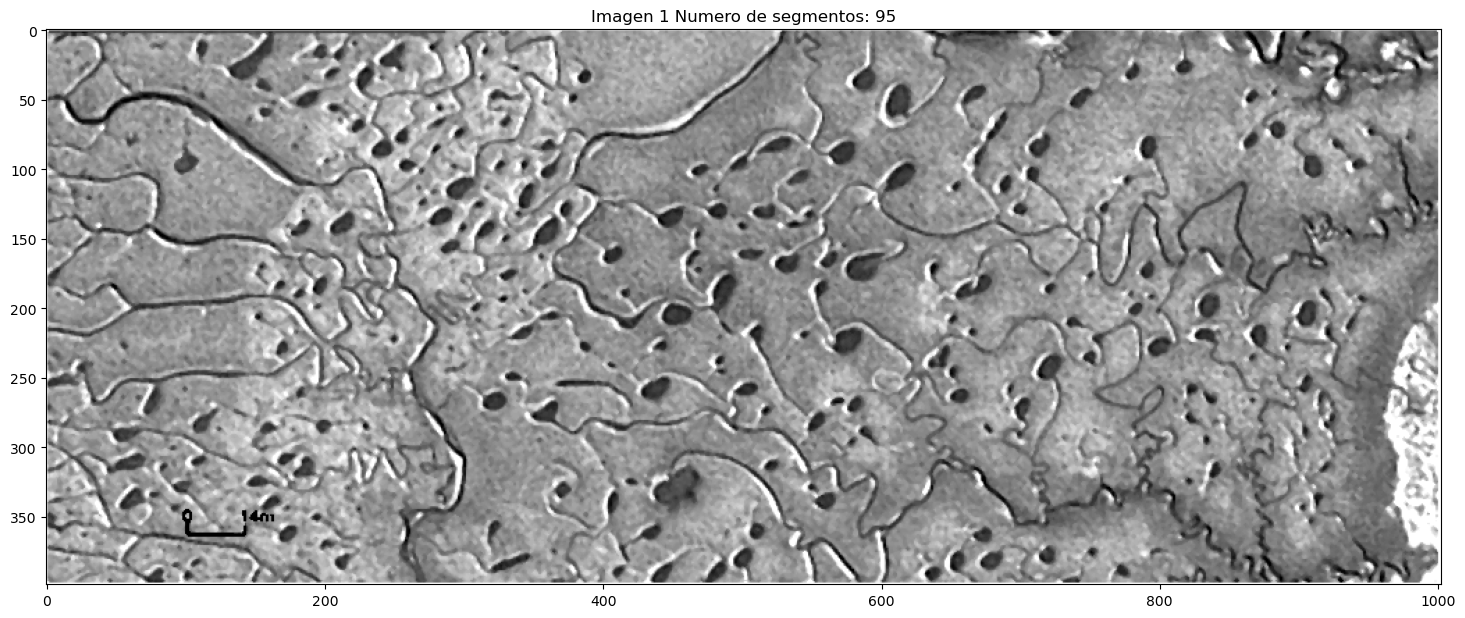

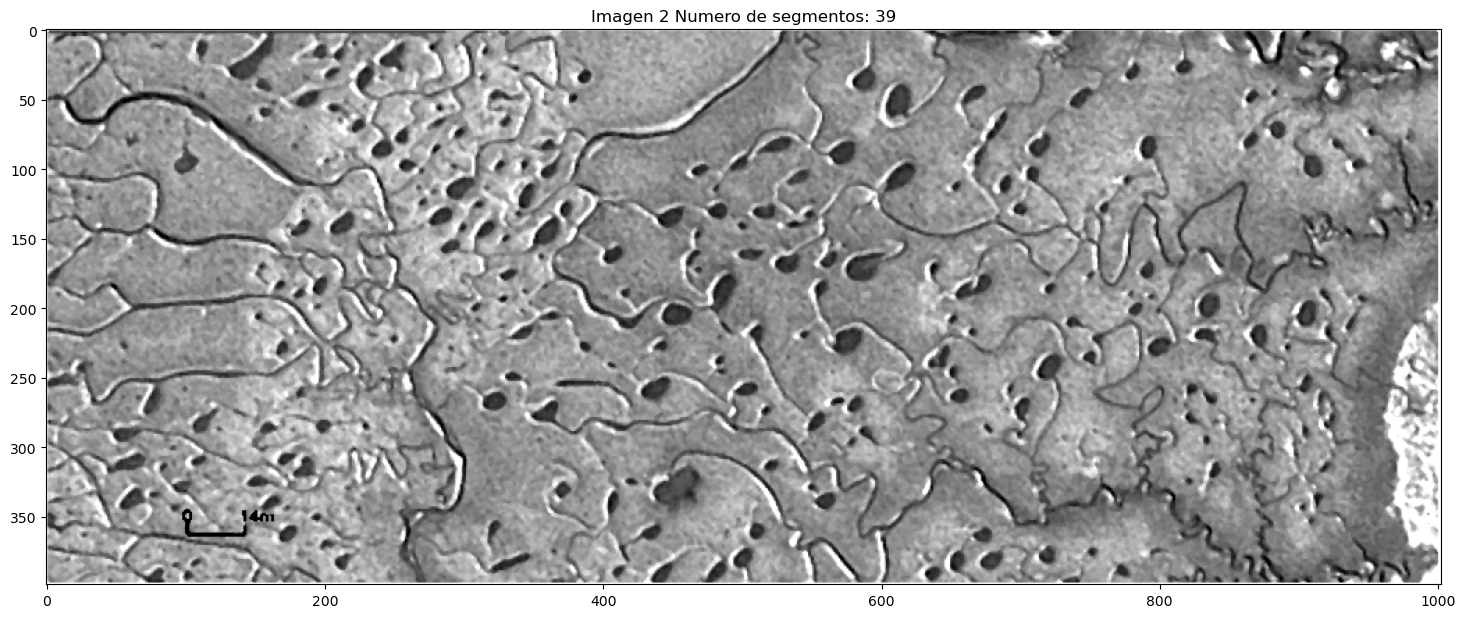

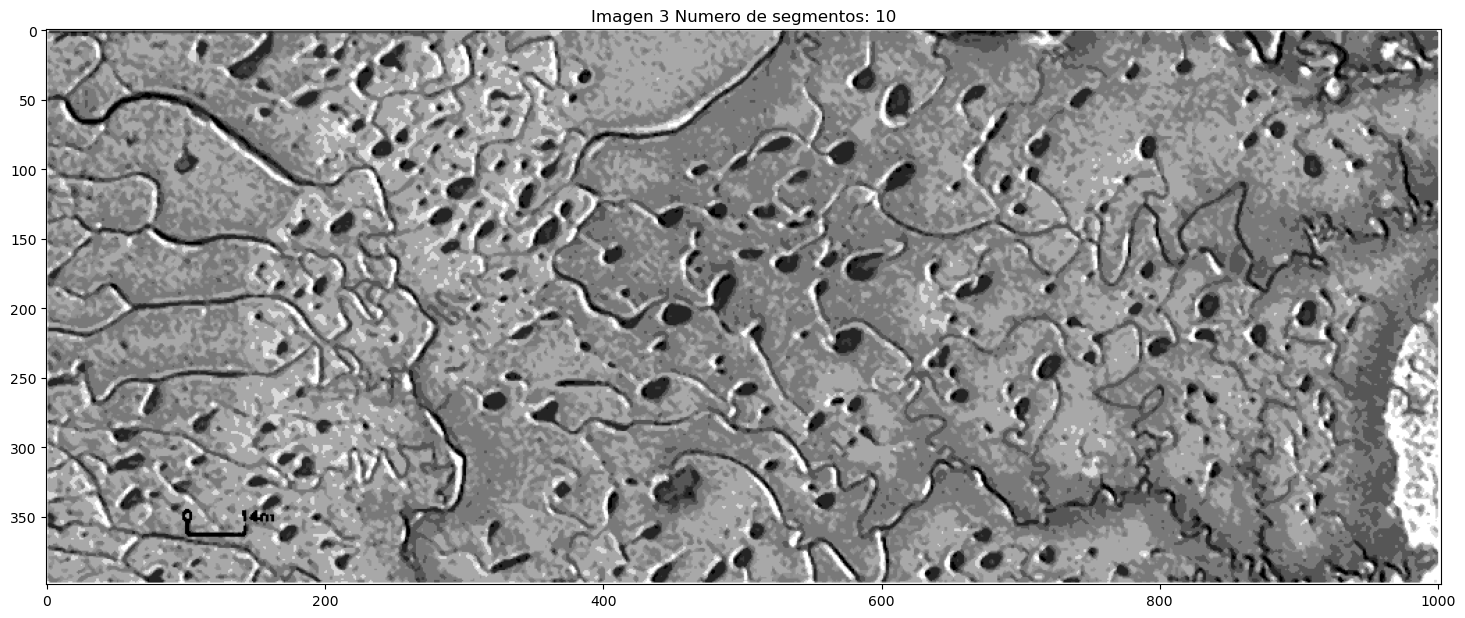

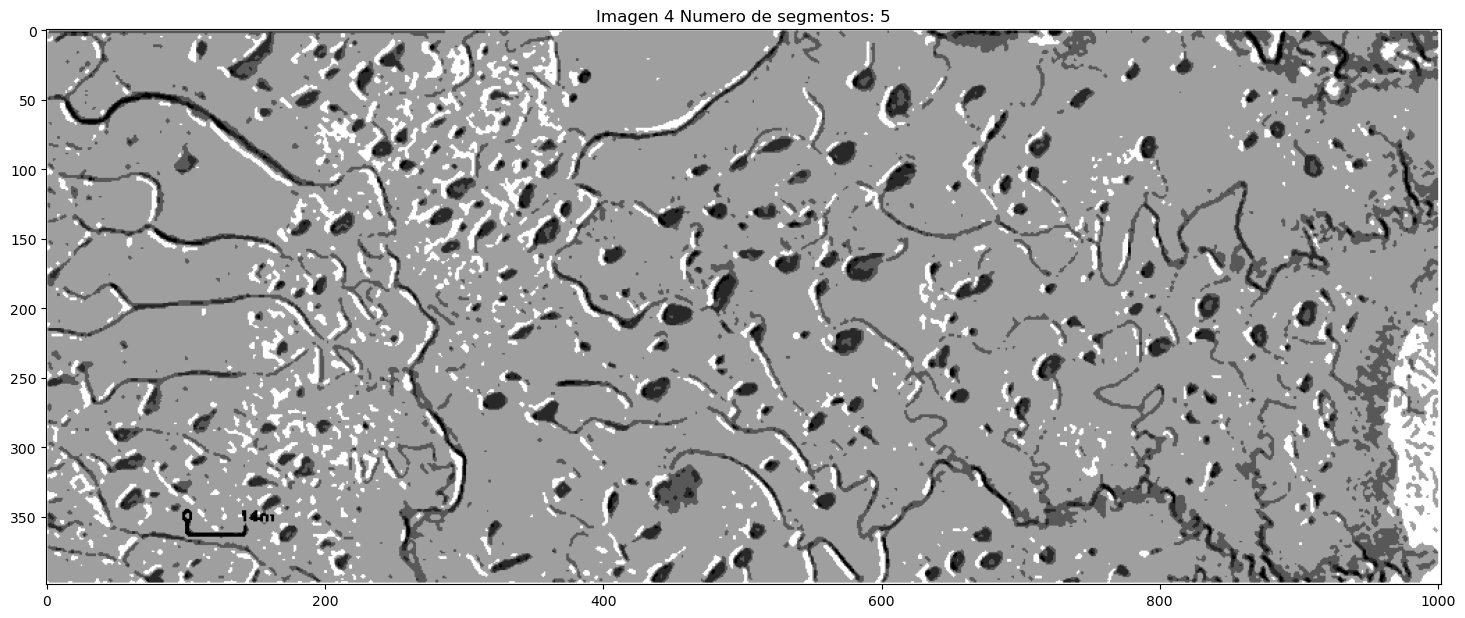

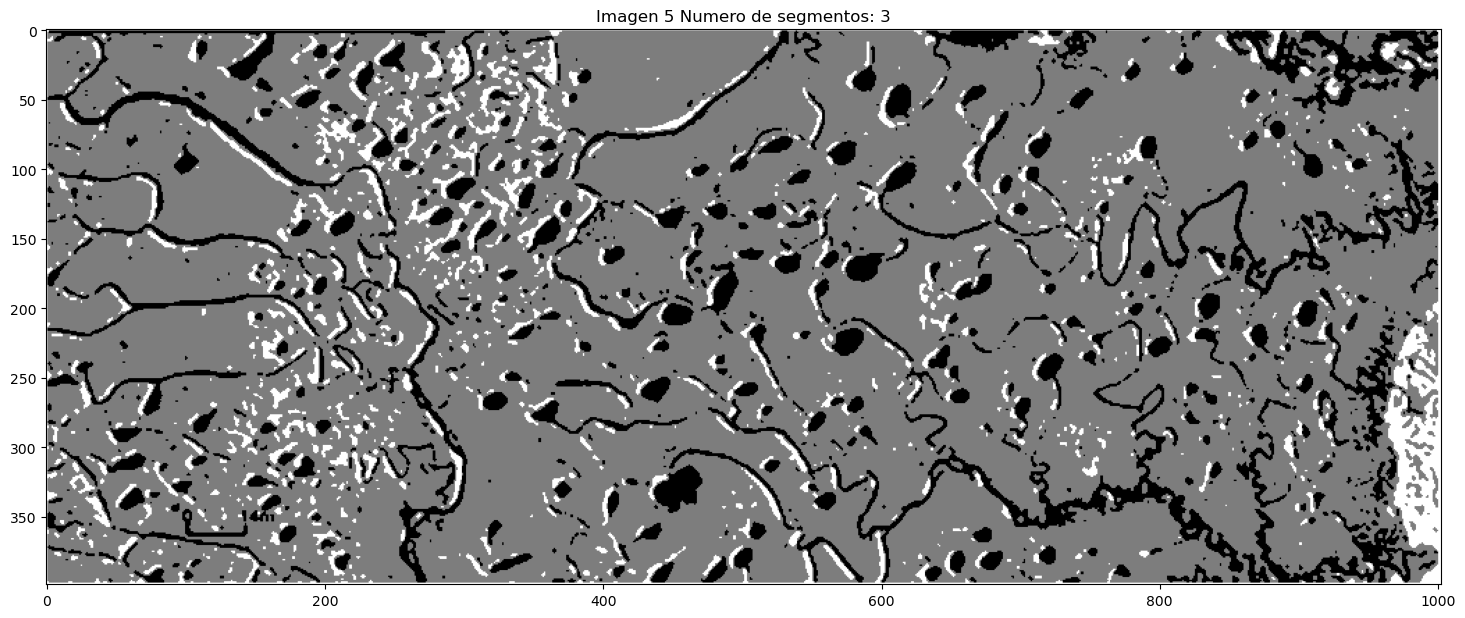

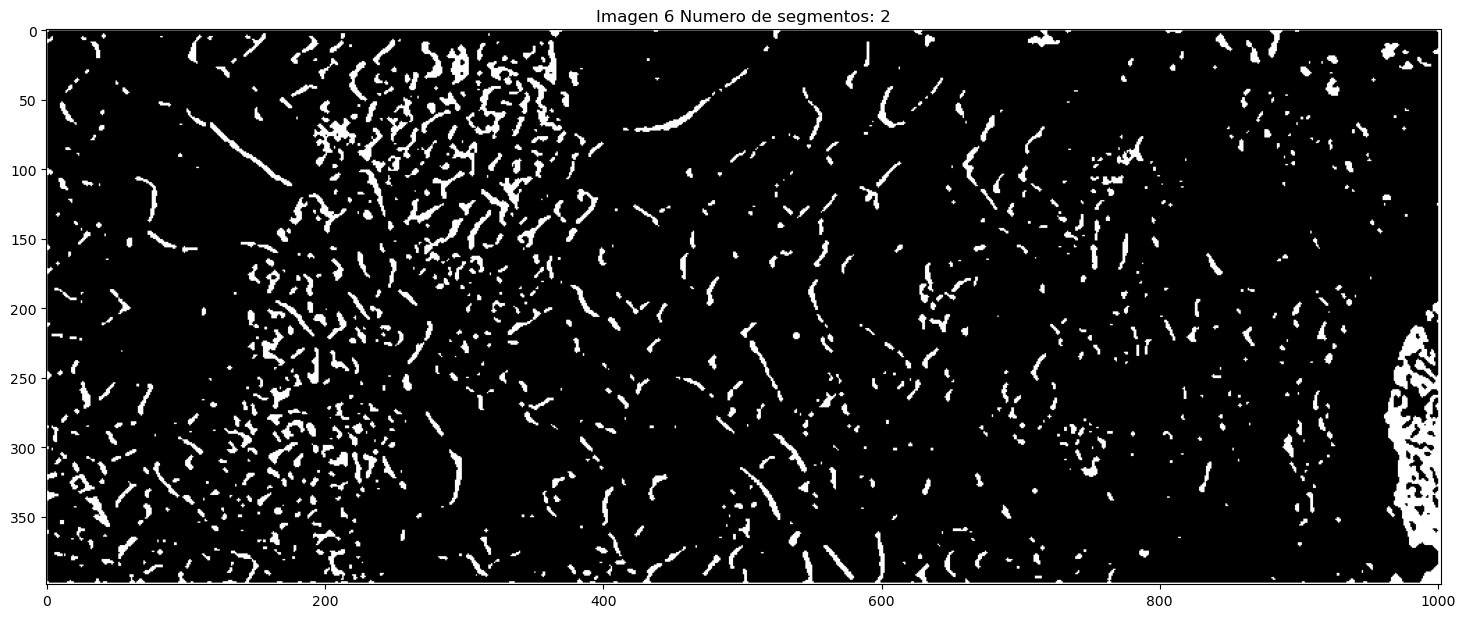

In [32]:
quantile_size = [0.0125, 0.0256 , 0.04, 0.06, 0.12, 0.2]
ms_results = {}
x = 1
for qua_value in quantile_size:
    mean_image, segment = MeanShiftFunc(img_rgb, qua_value)
    img_ms = np.clip(mean_image/255.,0.,1.)
    yiq_ms = np.clip(nf.RGB_to_YIQ(img_ms),0.,1.)
    bandaY_ms = yiq_ms[:,:,0]
    ms_results[x] = (bandaY_ms, segment)
    fig, ax = plt.subplots()
    ax.imshow(bandaY_ms, 'gray')
    ax.set_title("Imagen {} Numero de segmentos: {}".format(x,segment))
    fig.set_size_inches(18, 10, forward=True)
    x = x + 1

## Binarización

Una vez suavizada y segmentada la imagen con el método de MeanShift se continúa con el paso de binarización, que consiste en convertir una imagen en escala de grises en una imagen binaria, donde los píxeles son 0 o 255. En este caso el objeto (los ponds) serán identificados con color blanco y el fondo de color negro.
Se puede aplicar manualmente un umbral simple donde se define un valor de umbral T y luego se establece todas las intensidades de píxeles inferiores a T a 0. 
El **Método de Otsu** calcula automáticamente un valor óptimo de T

La imagen elegida fue la Número 4 con 5 segmentos la cual se multiplica por 255.

In [87]:
bin_255 = np.clip((ms_results[4][0]*255),0,255).astype(np.uint8)

Valor de umbral de Otsu: 84.0


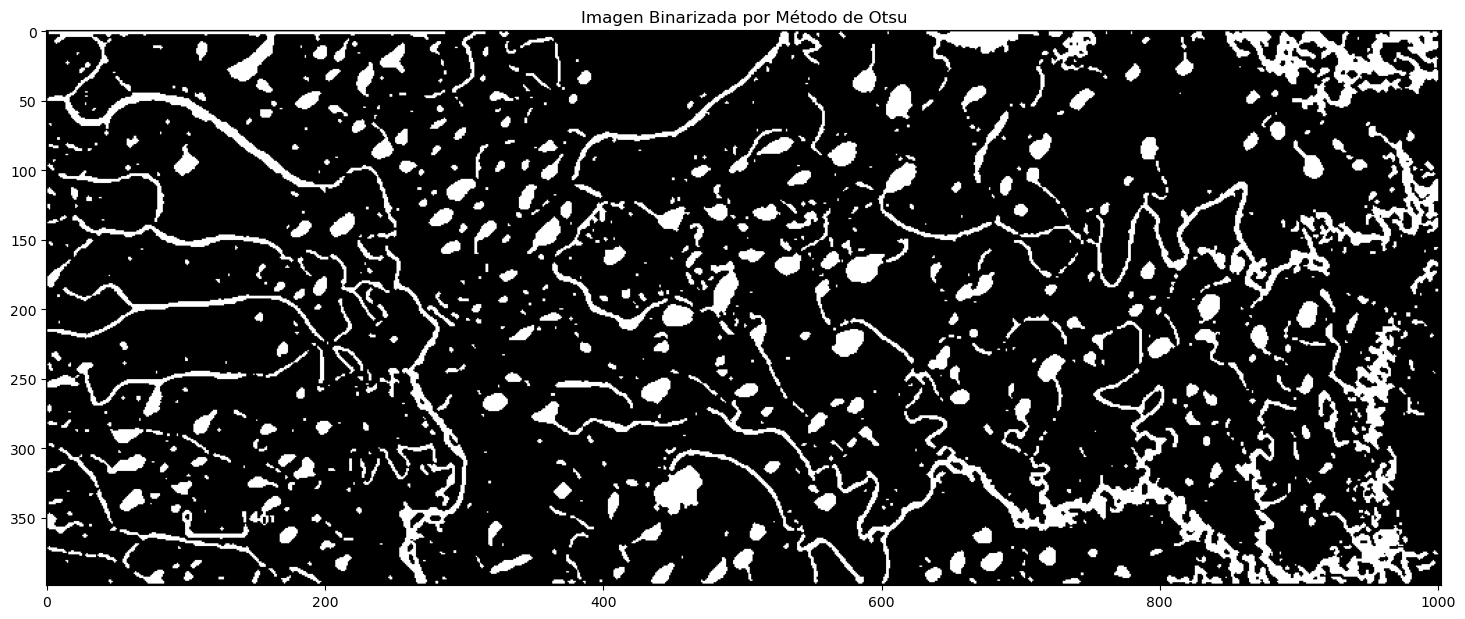

In [88]:
T,thresh = cv.threshold(bin_255,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
print("Valor de umbral de Otsu: {}".format(T))
fig, ax = plt.subplots()
ax.imshow(thresh, 'gray')
ax.set_title("Imagen Binarizada por Método de Otsu")
fig.set_size_inches(18, 10, forward=True)

## Contornos

Una vez obtenida la imagen binarizada se continua con la detección de bordes para posteriormente calcular el área y perímetro que ocupa los ponds en la arena de la playa. Para ello se utilizó el método de representación de contornos **Teh-Chin chain**. 

In [89]:
contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE ,cv.CHAIN_APPROX_TC89_L1)
print("Nºs de contornos:",len(contours))

Nºs de contornos: 1026


Para dibujar el area de cada contorno en neceasrio representar la imagen en sus 3 bandas

In [130]:
a = list(thresh.shape)
a.append(3)
a = tuple(a)
result = np.zeros(a)
result[:,:,0] = thresh
result[:,:,1] = thresh
result[:,:,2] = thresh

In [158]:
# drawing contours
img2 = result.copy()
cnt=contours[0]
cnt_areas = []
for i, cnt in enumerate(contours):
    M = cv.moments(cnt) #centroide
    if M['m00'] != 0.0:
        x1 = int(M['m10']/M['m00'])
        y1 = int(M['m01']/M['m00'])
        area = cv.contourArea(cnt)
        perimeter = cv.arcLength(cnt, True)
        perimeter = round(perimeter, 4)
        cnt_areas.append({
            'i':i+1,
            'cnt':cnt,
            'area':area,
            'perimeter':perimeter,
            'x1': x1,
            'y1': y1
        })
    else:
        continue

cnt_areas=sorted(cnt_areas, key=lambda i: i['area'], reverse=True)

In [159]:
colors = []
colors.append((255, 0, 0)) #rojo 
colors.append((0, 255, 0)) #verde
colors.append((0, 0, 255)) #azul
colors.append((255, 255, 0)) #amarillo
colors.append((255, 0, 255)) #magenta
colors.append((0, 255, 255)) #cian
colors.append((0, 165, 255)) #naranja
colors.append((138, 43, 226)) #violeta
colors.append((64, 224, 208)) #turquesa
colors.append((255, 182, 193)) #rosa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


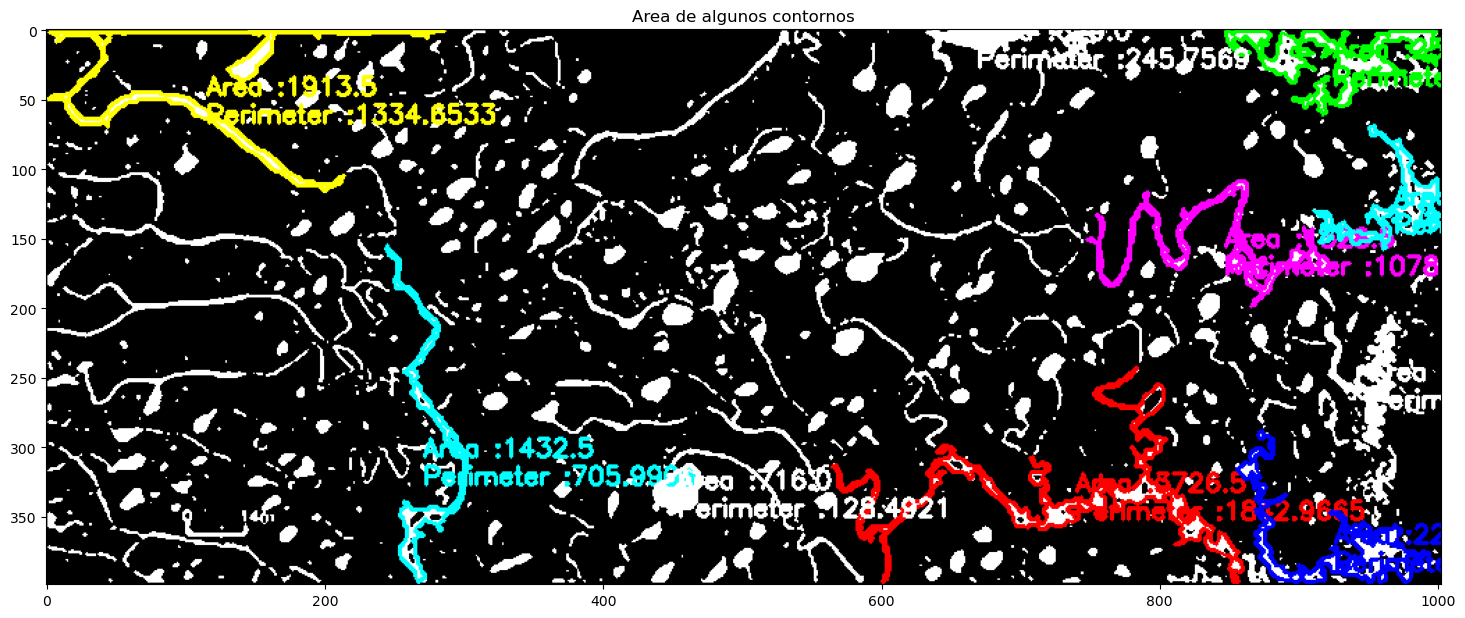

In [160]:
for i, area in enumerate(cnt_areas[:10]):
    img1 = cv.drawContours(img2, [area['cnt']], -1, colors[i], 2)
    cv.putText(img2, f"Area :{area['area']}", (area['x1'], area['y1']), cv.FONT_HERSHEY_SIMPLEX, 0.6, colors[i], 2)
    cv.putText(img2, f"Perimeter :{area['perimeter']}", (area['x1'], area['y1']+20), cv.FONT_HERSHEY_SIMPLEX, 0.6, colors[i], 2)

fig, ax = plt.subplots()
ax.imshow(img2, 'gray')
ax.set_title("Area de algunos contornos")
fig.set_size_inches(18, 10, forward=True)

In [166]:
total = [ item['area'] for item in cnt_areas]
print(f"Suma total de las Areas: {sum(total)}")

Suma total de las Areas: 46419.5
